#  Определение частей речи с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
* https://notebook.community/sameersingh/uci-statnlp/tutorials/rnn_examples
* https://github.com/bentrevett/pytorch-pos-tagging/blob/master/1_bilstm.ipynb
* https://github.com/Koziev/rupostagger

## Задачи для совместного разбора

1\. Рассмотрите пример работы двунаправленного рекуррентого слоя

![bi-lstm](https://discuss.pytorch.org/uploads/default/original/3X/d/3/d34a27c490e75c1a0a96128c5726ab6656427d90.jpeg)

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
batch_size = 16
seq_len = 5
embedding_dim = 32
x = th.rand(batch_size, seq_len, embedding_dim)

In [ ]:
hidden_size = 15
lstm = nn.LSTM(
    input_size=embedding_dim,
    hidden_size=hidden_size,
    batch_first=True,
    bidirectional=True,
)

In [ ]:
o, (h, c) = lstm(x)

In [ ]:
nn.Dropout()(o)

In [ ]:
print(o.shape, h.shape, c.shape)

torch.Size([16, 5, 30]) torch.Size([2, 16, 15]) torch.Size([2, 16, 15])


In [ ]:
o[0, -1]

tensor([-0.2366,  0.0591,  0.0873,  0.0445,  0.0334,  0.1333, -0.2374, -0.3090,
         0.0301,  0.0683, -0.1936, -0.2158,  0.0804,  0.0198,  0.2131, -0.0653,
        -0.2681, -0.0627, -0.0680,  0.1504,  0.0884, -0.0267,  0.1027, -0.1189,
         0.0739,  0.0369, -0.0195,  0.1079, -0.0873, -0.0524],
       grad_fn=<SelectBackward0>)

In [ ]:
h[0, 0]

tensor([-0.2366,  0.0591,  0.0873,  0.0445,  0.0334,  0.1333, -0.2374, -0.3090,
         0.0301,  0.0683, -0.1936, -0.2158,  0.0804,  0.0198,  0.2131],
       grad_fn=<SelectBackward0>)

In [ ]:
h[0, 0].shape

torch.Size([15])

2\. Рассмотрите пример работы многоуровневого рекуррентого слоя

![stacked-rnn](https://lh6.googleusercontent.com/rC1DSgjlmobtRxMPFi14hkMdDqSkEkuOX7EW_QrLFSymjasIM95Za2Wf-VwSC1Tq1sjJlOPLJ92q7PTKJh2hjBoXQawM6MQC27east67GFDklTalljlt0cFLZnPMdhp8erzO)

In [ ]:
batch_size = 16
seq_len = 5
embedding_dim = 32
x = th.rand(batch_size, seq_len, embedding_dim)

In [ ]:
hidden_size = 15
lstm = nn.LSTM(
    input_size=embedding_dim,
    hidden_size=hidden_size,
    batch_first=True,
    bidirectional=True,
    num_layers=2
)

In [ ]:
o, (h, c) = lstm(x)

In [ ]:
print(o.shape, h.shape, c.shape)

torch.Size([16, 5, 15]) torch.Size([2, 16, 15]) torch.Size([2, 16, 15])


## Задачи для самостоятельного решения

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import numpy as np
import re
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torchmetrics as M
from sklearn.metrics import classification_report

<p class="task" id="1"></p>

### 1
Считайте файл `pos_data.txt` и создайте на его основе два списка `X` и `y` следующего вида.

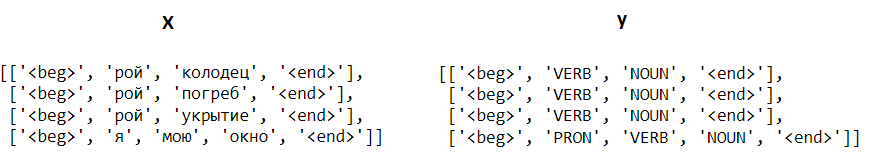

Найдите 75% квантиль распределения длин предложений и удалите из выборки те предложения, которые длиннее данного значения. Выведите на экран пару `(X[0], y[0])` и количество элементов в `X` и `y`.

- [ ] Проверено на семинаре

In [ ]:
with open('/kaggle/input/04-rnn/pos_data.txt') as f:
    lines = f.readlines()

In [ ]:
lines[:10]

['0\t<beg>\t<beg>\n',
 '1\tрой\tVERB|Mood=Imp|Number=Sing|Person=2|VerbForm=Fin\n',
 '2\tколодец\tNOUN|Case=Acc|Gender=Masc|Number=Sing\n',
 '3\t<end>\t<end>\n',
 '\n',
 '0\t<beg>\t<beg>\n',
 '1\tрой\tVERB|Mood=Imp|Number=Sing|Person=2|VerbForm=Fin\n',
 '2\tпогреб\tNOUN|Case=Acc|Gender=Masc|Number=Sing\n',
 '3\t<end>\t<end>\n',
 '\n']

In [ ]:
data = []

for line in lines:
    line = line.replace('\n', '').split('\t')
    data.append(line)

data[:10]

[['0', '<beg>', '<beg>'],
 ['1', 'рой', 'VERB|Mood=Imp|Number=Sing|Person=2|VerbForm=Fin'],
 ['2', 'колодец', 'NOUN|Case=Acc|Gender=Masc|Number=Sing'],
 ['3', '<end>', '<end>'],
 [''],
 ['0', '<beg>', '<beg>'],
 ['1', 'рой', 'VERB|Mood=Imp|Number=Sing|Person=2|VerbForm=Fin'],
 ['2', 'погреб', 'NOUN|Case=Acc|Gender=Masc|Number=Sing'],
 ['3', '<end>', '<end>'],
 ['']]

In [ ]:
X, y = [], []
temp_X, temp_y = [], []

for item in data:
    if item == ['']:
        X.append(temp_X)
        y.append(temp_y)
        temp_X, temp_y = [], []
    else:
        temp_X.append(item[1])
        temp_y.append(re.sub(r'\|.+', '', item[2]))

In [ ]:
data = pd.DataFrame({'X': X,
                     'y': y})

X_lengths = data['X'].str.len()
y_lengths = data['y'].str.len()

X_quantile = X_lengths.quantile(0.75)
y_quantile = y_lengths.quantile(0.75)

X = data['X'][X_lengths <= X_quantile]
y = data['y'][y_lengths <= y_quantile]

print(f"{X[0], y[0]=}")
print(f"{len(X)=}")
print(f"{len(y)=}")

X[0], y[0]=(['<beg>', 'рой', 'колодец', '<end>'], ['<beg>', 'VERB', 'NOUN', '<end>'])
len(X)=784616
len(y)=784616


<p class="task" id="2"></p>

### 2
Разделите данные на обучающую и тестовую выборку. Создайте два Vocab на основе загруженных данных: `vocab_X` для слов и `vocab_y` для частей речи. Добавьте в словари специальные токены `<PAD>`, `<UNK>`, `<beg>`, `<end>`. Выведите на экран количество токенов в полученных словарях.

- [ ] Проверено на семинаре

In [ ]:
X_train, X_test = train_test_split(X, test_size=0.2)
y_train, y_test = train_test_split(y, test_size=0.2)

vocab_X = build_vocab_from_iterator(X_train, specials=['<UNK>', '<PAD>', '<beg>', '<end>'])
vocab_X.set_default_index(0)

vocab_y = build_vocab_from_iterator(y_train, specials=['<UNK>', '<PAD>', '<beg>', '<end>'])
vocab_y.set_default_index(0)

print(f"{len(vocab_X)=}")
print(f"{len(vocab_y)=}")

len(vocab_X)=212217
len(vocab_y)=20


<p class="task" id="3"></p>

### 3
Создайте класс `POSTaggingDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)`, где x - это набор индексов токенов для предложений на русском языке, а `y` - набор индексов токенов для соответствующих частей речи. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины. Создайте два датасета: для обучающей и тестовой выборки.

Выведите на экран формы тензоров `x` и `y`:

```python
x, y = train_dset[:5]
print(x.shape, y.shape)
```



- [ ] Проверено на семинаре

In [ ]:
class POSTaggingDataset(Dataset):
    def __init__(self, X, y, X_transform, y_transform):
        self.X = X
        self.y = y
        self.X_transform = X_transform
        self.y_transform = y_transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X_i = self.X.iloc[index]
        y_i = self.y.iloc[index]

        if isinstance(X_i, list):
            X_transformed = self.X_transform(X_i)
            y_transformed = self.y_transform(y_i)
        else:
            #X_transformed = X_i.apply(lambda x: self.X_transform(x)).tolist()
            #y_transformed = y_i.apply(lambda x: self.y_transform(x)).tolist()
            X_transformed = torch.stack(X_i.apply(lambda x: self.X_transform(x)).tolist())
            y_transformed = torch.stack(y_i.apply(lambda x: self.y_transform(x)).tolist())

        return (X_transformed, y_transformed)

In [ ]:
X_transform = T.Sequential(
    T.VocabTransform(vocab_X),
    T.Truncate(max_seq_len=10),
    T.ToTensor(),
    T.PadTransform(max_length=10, pad_value=vocab_X.lookup_indices(['<PAD>'])[0]))

y_transform = T.Sequential(
    T.VocabTransform(vocab_y),
    T.Truncate(max_seq_len=10),
    T.ToTensor(),
    T.PadTransform(max_length=10, pad_value=vocab_y.lookup_indices(['<PAD>'])[0]))

In [ ]:
dataset_train = POSTaggingDataset(X_train, y_train, X_transform, y_transform)
print(dataset_train[0], '\n\n')
print(dataset_train[:2])

(tensor([   2, 1487,  160,   11,    3,    1,    1,    1,    1,    1]), tensor([2, 6, 8, 9, 4, 4, 3, 1, 1, 1])) 


(tensor([[    2,  1487,   160,    11,     3,     1,     1,     1,     1,     1],
        [    2,  2500,    36, 18590,     4,     3,     1,     1,     1,     1]]), tensor([[ 2,  6,  8,  9,  4,  4,  3,  1,  1,  1],
        [ 2,  6, 12,  8,  6,  5,  3,  1,  1,  1]]))


In [ ]:
dataset_test = POSTaggingDataset(X_test, y_test, X_transform, y_transform)
print(dataset_test[0], '\n\n')
print(dataset_test[:2])

(tensor([    2,   650,   144,    55,   140, 34051,     3,     1,     1,     1]), tensor([ 2,  8, 12,  6,  4,  5,  3,  1,  1,  1])) 


(tensor([[    2,   650,   144,    55,   140, 34051,     3,     1,     1,     1],
        [    2,    17,    30,  1170,    36, 18217,     4,     3,     1,     1]]), tensor([[ 2,  8, 12,  6,  4,  5,  3,  1,  1,  1],
        [ 2,  8,  6,  5,  6,  4,  4,  5,  3,  1]]))


In [ ]:
x, y = dataset_train[:5]
print(f"{x.shape=}, {y.shape=}")

x.shape=torch.Size([5, 10]), y.shape=torch.Size([5, 10])


<p class="task" id="4"></p>

### 4
Создайте и обучите модель для предсказания частей речи. Игнорируйте токен `<PAD>` при расчете ошибки. Во время обучения выводите на экран значения функции потерь для эпохи, значение accuracy для эпохи.

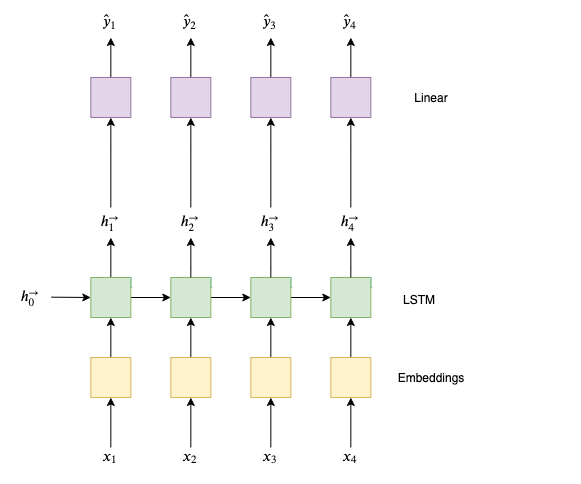

- [ ] Проверено на семинаре

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_loader = DataLoader(dataset_train, batch_size=1500, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=1500, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super().__init__()

        self.emb = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        emb = self.emb(x)
        out, h = self.rnn(emb)
        out = out.reshape(out.shape[0] * out.shape[1], out.shape[2]).to(device)
        out = self.linear(out)
        return out

In [ ]:
num_epochs = 5

model = Net(input_size=len(vocab_X), embedding_size=100, hidden_size=100, output_size=len(vocab_y)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses_list = []

for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss = 0.0
    accuracy = M.Accuracy(task='multiclass', num_classes=len(vocab_y)).to(device)

    for words, parts in train_loader:
        words = words.to(device)
        parts = parts.to(device)

        output = model(words)
        loss = criterion(output, parts.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        accuracy.update(output.argmax(dim=1), parts.view(-1))

    epoch_accuracy = accuracy.compute()
    train_losses_list.append(epoch_loss)

    print(f'{epoch=}, {epoch_loss=}, {epoch_accuracy=}')

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_jit_internal.py:1297: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(
 20%|██        | 1/5 [01:39<06:36, 99.16s/it]

epoch=1, epoch_loss=689.9798603057861, epoch_accuracy=tensor(0.4450, device='cuda:0')


 40%|████      | 2/5 [03:16<04:53, 97.88s/it]

epoch=2, epoch_loss=683.5508879423141, epoch_accuracy=tensor(0.4483, device='cuda:0')


 60%|██████    | 3/5 [04:48<03:10, 95.34s/it]

epoch=3, epoch_loss=678.4467725753784, epoch_accuracy=tensor(0.4510, device='cuda:0')


 80%|████████  | 4/5 [06:21<01:34, 94.27s/it]

epoch=4, epoch_loss=667.4312523603439, epoch_accuracy=tensor(0.4593, device='cuda:0')


100%|██████████| 5/5 [07:50<00:00, 94.00s/it]

epoch=5, epoch_loss=655.6833955049515, epoch_accuracy=tensor(0.4705, device='cuda:0')


<p class="task" id="5"></p>

### 5
Постройте и выведите на экран classification report на основе тестовой выборки. Выведите на экран пример предсказания частей речи обученной моделью.

- [ ] Проверено на семинаре

In [ ]:
pred = []
true = []

with torch.no_grad():
    for words, parts in test_loader:
        words = words.to(device)
        parts = parts.to(device)

        output = model(words)
        _, predicted = torch.max(output, dim=1)

        pred.extend(predicted.cpu().numpy().flatten())
        true.extend(parts.cpu().numpy().flatten())

print(classification_report(true, pred))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.56      0.85      0.67    376009
           2       0.99      1.00      0.99    155194
           3       0.22      0.16      0.18    135660
           4       0.19      0.14      0.16    200069
           5       0.22      0.23      0.23    165328
           6       0.29      0.47      0.36    173737
           7       0.11      0.01      0.02     91831
           8       0.21      0.31      0.25     86725
           9       0.08      0.00      0.01     61967
          10       0.09      0.00      0.01     58041
          11       0.08      0.00      0.01     28764
          12       0.06      0.00      0.00     26580
          13       0.00      0.00      0.00      6452
          14       0.00      0.00      0.00      1040
          15       0.00      0.00      0.00       576
          16       0.00      0.00      0.00       443
          17       0.00      0.00      0.00       423
          18       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
list_example = [dataset_test[0][0].tolist()]
tensor_example = torch.LongTensor(list_example).to(device)
with torch.no_grad():
    output = model(tensor_example)
    _, pred = torch.max(output, dim=1)

print(f"example: {vocab_X.lookup_tokens(dataset_test[0][0].tolist())}")
print(f"pred: {vocab_y.lookup_tokens(pred.tolist())}")

example: ['<beg>', 'президент', 'опять', 'очень', 'быстро', 'поработает', '<end>', '<PAD>', '<PAD>', '<PAD>']
pred: ['<beg>', 'PRON', 'VERB', 'VERB', 'PUNCT', 'VERB', 'PUNCT', '<PAD>', '<PAD>', '<PAD>']


<p class="task" id="6"></p>

### 6
Решите задачи 4-5, используя двунаправленный рекуррентный слой.

![biLSTM](https://camo.githubusercontent.com/9bc90608fecf249e80f0ec0053469e91ff6347922aa136fda5bbec3de8303862/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d706f732d74616767696e672f626c6f622f6d61737465722f6173736574732f706f732d6269646972656374696f6e616c2d6c73746d2e706e673f7261773d31)

- [ ] Проверено на семинаре

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super().__init__()

        self.emb = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        emb = self.emb(x)
        out, h = self.rnn(emb)
        out = out.reshape(out.shape[0] * out.shape[1], out.shape[2]).to(device)
        out = self.linear(out)
        return out

In [ ]:
num_epochs = 5

model = Net(input_size=len(vocab_X), embedding_size=100, hidden_size=100, output_size=len(vocab_y)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses_list = []

for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss = 0.0
    accuracy = M.Accuracy(task='multiclass', num_classes=len(vocab_y)).to(device)

    for words, parts in train_loader:
        words = words.to(device)
        parts = parts.to(device)

        output = model(words)
        loss = criterion(output, parts.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        accuracy.update(output.argmax(dim=1), parts.view(-1))

    epoch_accuracy = accuracy.compute()
    train_losses_list.append(epoch_loss)

    print(f'{epoch=}, {epoch_loss=}, {epoch_accuracy=}')

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_jit_internal.py:1297: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(
 20%|██        | 1/5 [01:31<06:06, 91.59s/it]

epoch=1, epoch_loss=689.90247631073, epoch_accuracy=tensor(0.4448, device='cuda:0')


 40%|████      | 2/5 [03:03<04:35, 91.87s/it]

epoch=2, epoch_loss=684.4139022827148, epoch_accuracy=tensor(0.4479, device='cuda:0')


 60%|██████    | 3/5 [04:34<03:02, 91.35s/it]

epoch=3, epoch_loss=679.094694018364, epoch_accuracy=tensor(0.4512, device='cuda:0')


 80%|████████  | 4/5 [06:05<01:31, 91.29s/it]

epoch=4, epoch_loss=664.9011126756668, epoch_accuracy=tensor(0.4632, device='cuda:0')


100%|██████████| 5/5 [07:36<00:00, 91.35s/it]

epoch=5, epoch_loss=647.5629379749298, epoch_accuracy=tensor(0.4785, device='cuda:0')


In [ ]:
pred = []
true = []

with torch.no_grad():
    for words, parts in test_loader:
        words = words.to(device)
        parts = parts.to(device)

        output = model(words)
        _, predicted = torch.max(output, dim=1)

        pred.extend(predicted.cpu().numpy().flatten())
        true.extend(parts.cpu().numpy().flatten())

print(classification_report(true, pred))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.56      0.87      0.68    376009
           2       0.99      1.00      0.99    155194
           3       0.22      0.19      0.20    135660
           4       0.20      0.14      0.16    200069
           5       0.22      0.21      0.21    165328
           6       0.28      0.44      0.34    173737
           7       0.11      0.01      0.02     91831
           8       0.20      0.25      0.23     86725
           9       0.08      0.00      0.01     61967
          10       0.08      0.00      0.01     58041
          11       0.08      0.01      0.02     28764
          12       0.04      0.00      0.00     26580
          13       0.00      0.00      0.00      6452
          14       0.00      0.00      0.00      1040
          15       0.00      0.00      0.00       576
          16       0.00      0.00      0.00       443
          17       0.00      0.00      0.00       423
          18       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
list_example = [dataset_test[0][0].tolist()]
tensor_example = torch.LongTensor(list_example).to(device)
with torch.no_grad():
    output = model(tensor_example)
    _, pred = torch.max(output, dim=1)

print(f"Вход: {vocab_X.lookup_tokens(dataset_test[0][0].tolist())}")
print(f"Предсказанные части речи: {vocab_y.lookup_tokens(pred.tolist())}")

Вход: ['<beg>', 'президент', 'опять', 'очень', 'быстро', 'поработает', '<end>', '<PAD>', '<PAD>', '<PAD>']
Предсказанные части речи: ['<beg>', 'VERB', 'VERB', 'VERB', 'ADJ', 'NOUN', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


## Обратная связь
- [x] Хочу получить обратную связь по решению